<a href="https://colab.research.google.com/github/GauravPatel89/EVA-Track3-Assignments/blob/master/Session13/Session13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Necessary modules

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE =  128#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE =  2e-5#@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  300#@param {type:"integer"}

https://mc.ai/tutorial-1-cifar10-with-google-colabs-free-gpu%E2%80%8A-%E2%80%8A92-5/

In [0]:
# Define a function for pytorch style weight initialization

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

## Block Design and Stride Strategy

### Initial Convolution Block
Standard ResNet model uses simple convolution block and maxpooling as intial layers to bring input image size quickly to 56x56. 

In our case we have CIFAR10 dataset. It has input size 32x32 so we cannot use maxPooling and simple convolution without padding as it will diminish the input size a lot even before ResNet blocks see them. So we use just a single simple convolution of 3x3 with padding(as SAME) to maintain the input size.

### ResNet Block

In ResNet blocks we have and identity connection from input added with residual connection to get output. All the ResNet blocks are similar in architecture except for number of channels used and stride. The stride selection for  first convolution block in ResNet determines if channel size will be reduced (Stride = 1 : no reduction, Stride > 1 : channel size reduction).

Standard ResNet models are defined as
ResNet-18 : (2,2,2,2)

Signifies

ResNetBlk(#kernels = c_in,stride = 2)->
ResNetBlk(#kernels = c_in,stride = 1)

ResNetBlk(#kernels = 2\*c_in,stride = 2)->
ResNetBlk(#kernels = 2\*c_in,stride = 1)

ResNetBlk(#kernels = 4\*c_in,stride = 2)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)

ResNetBlk(#kernels = 8\*c_in,stride = 2)->
ResNetBlk(#kernels = 8\*c_in,stride = 1)

ResNet-34 : (3,4,6,3)

Signifies

ResNetBlk(#kernels = c_in,stride = 2)->
ResNetBlk(#kernels = c_in,stride = 1)->
ResNetBlk(#kernels = c_in,stride = 1)

ResNetBlk(#kernels = 2\*c_in,stride = 2)->
ResNetBlk(#kernels = 2\*c_in,stride = 1)->
ResNetBlk(#kernels = 2\*c_in,stride = 1)->
ResNetBlk(#kernels = 2\*c_in,stride = 1)

ResNetBlk(#kernels = 4\*c_in,stride = 2)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)


ResNetBlk(#kernels = 8\*c_in,stride = 2)->
ResNetBlk(#kernels = 8\*c_in,stride = 1)->
ResNetBlk(#kernels = 8\*c_in,stride = 1)


So in case of ResNet we have Stride=2 four times. Each such block reduces channel size by half. In our case since input image size is 32x32 applying downsampling 4 times will reduce it to 2x2. This is too small a size to represent anything. Hence we cannot follow the same stride strategy. 

We will follow following strategy

ResNetBlk(#kernels = c_in,stride = 1)->
ResNetBlk(#kernels = c_in,stride = 1)

ResNetBlk(#kernels = 2\*c_in,stride = 2)->
ResNetBlk(#kernels = 2\*c_in,stride = 1)

ResNetBlk(#kernels = 4\*c_in,stride = 1)->
ResNetBlk(#kernels = 4\*c_in,stride = 1)

ResNetBlk(#kernels = 8\*c_in,stride = 2)->
ResNetBlk(#kernels = 8\*c_in,stride = 1)

So we will downsample our channel only twice so we will still have 8x8 size when we reach final layers. This is sufficient to carry information. 
If we look at the strategy we apply first downsampling in 2nd ResNet block. By this time our Receptive field is 11x11 which is where edges and gradients would have formed for 32x32 image.


Further while defining the ResNet block we must pay attention to identity connection between input and output. Since we are adding identity and residual connections, their both their channel size and number should match. This is done by using 1x1 convolution with stride as shown in the block definition.



In [0]:
# Define Simple Convolution block
class ConvBN(tf.keras.Model):
  def __init__(self, c_out, stride = 1):
    super().__init__()
    # Convolution with 3x3 kernel and padding to maintain channel size
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=stride,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    # Batch normalization
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    # Chain the block defined above to form a simple convolution block
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
# Define a ResNet block

class ResBlk(tf.keras.Model):
  # #of channels in and out are passed as argument. These help us in matching input and output
  # channel size for identity connection before adding it with residual connection
  def __init__(self,c_in, c_out, stride = 1):
    super().__init__()
    self.stride = stride
    self.c_in = c_in
    self.c_out = c_out
    self.conv1 = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=stride,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.conv2 = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    
    # Define a layer with 1x1 convolution to take care of input output size matching
    self.resAdjust = tf.keras.layers.Conv2D(filters=c_out, kernel_size=1,strides=stride,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)

    self.conv3 = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn3 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.conv4 = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn4 = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)


  def call(self, inputs):
    h1 = tf.nn.relu(self.bn1(self.conv1(inputs)))
    h1 = self.bn2(self.conv2(h1))

    # We will need size adjustment in two cases
    # 1. When we have stride != 1 since it will reduce channel size
    # 2. When we are transitioning between blocks and #channels are different
    if self.stride != 1 or self.c_in != self.c_out:
      h1 = self.resAdjust(inputs) + h1
    else:
      h1 = inputs + h1
      
    h1 = tf.nn.relu(h1)  


    h2 = tf.nn.relu(self.bn3(self.conv3(h1)))
    h2 = self.bn4(self.conv4(h2))

    h = h1 + h2
      
    h = tf.nn.relu(h)  

    return h

In [0]:
class ResNet18(tf.keras.Model):
  def __init__(self, c=64 ):
    super().__init__()
    
    self.init_conv_bn = ConvBN(c,stride = 1)    # i/p: 32x32x3   o/p: 32x32x64   RF: 3
    self.blk1 = ResBlk(c, c, stride = 1)        # i/p: 32x32x64  o/p: 32x32x64   RF: 11
    self.blk2 = ResBlk(c, c*2, stride = 2)      # i/p: 32x32x64  o/p: 16x16x128  RF: 25
    self.blk3 = ResBlk(c*2, c*4, stride = 1)    # i/p: 16x16x128 o/p: 16x16x256  RF: 41
    self.blk4 = ResBlk(c*4, c*8, stride = 2)    # i/p: 16x16x256 o/p:  8x 8x512  RF: 69
    
    #After convolution blocks we have GAP layer followed by FCN to get final 10 class o/p
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    

  def call(self, x, y):
    # Chain different blocks defined earlier
    h = self.blk4(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    
    h = self.linear(self.pool(h))
    
    # Find cross entropy and softmax over it
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)

    # Find number of correct predictions
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
# Download CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)

y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Use standard mean and std for dataset. 3 means and 3 std correspond to 3 chnnels (RGB)
train_mean = np.array([0.4914, 0.4822, 0.4465])
train_std = np.array([0.2023, 0.1994, 0.2010])

normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# Normalize training and test dataset
x_train = normalize(pad4(x_train))
xx_test = normalize(x_test)

In [0]:
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import os

# Define Learning rate finder class
class LR_Finder():
    
    # Define constructor
    def __init__(self, model):
        self.model = model
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        
        

    def find(self, x_train, y_train, start_lr=1e-5, end_lr=10, batch_size=128,step_size=None, beta=0.98):

        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size) # Calculate multiplication factor for LR calculation

        # Define a function which will exponentially increment Learning Rate w.r.t training iteration
        lr_func = lambda: self.start_lr * (self.lr_mult ** (self.iteration)) 

        # feed this lr_func to tensorflow SGD optimizer 
        tempOpt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

        train_loss = test_loss = train_acc = test_acc = 0.0
                
        
        train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(batch_size)
        tf.keras.backend.set_learning_phase(1)

        for (x, y) in tqdm(train_set):

          lr = lr_func()
          
          with tf.GradientTape() as tape:
            loss, correct = model(x, y)

          var = model.trainable_variables
          grads = tape.gradient(loss, var)
          for g, v in zip(grads, var):
            g += v * WEIGHT_DECAY * BATCH_SIZE
          tempOpt.apply_gradients(zip(grads, var))

          loss1 = (loss/batch_size)

          loss, correct = model(x, y)

          loss = (loss/batch_size)  
          # Smoothen the loss log so that its plot will be better help visualization
          self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
          smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
          
          self.losses.append(loss)
          self.smoothed_losses.append(smoothed_loss)
          self.lrs.append(lr)
          self.iterations.append(self.iteration)  

          # Check if the loss is not exploding
          if self.iteration>1 and smoothed_loss > self.best_loss * 5:
              print('loss shooting up return')
              break

          if smoothed_loss < self.best_loss or self.iteration==1:
              self.best_loss = smoothed_loss

          self.iteration += 1            
               
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

Using TensorFlow backend.


In [0]:
model = ResNet18()

In [0]:
lr_finder = LR_Finder(model)
lr_finder.find(x_train, y_train, start_lr=1e-8, end_lr=1, batch_size=BATCH_SIZE,step_size=np.ceil(len_train/BATCH_SIZE), beta=0.98)

loss shooting up return


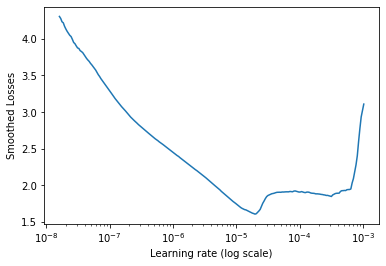

In [0]:
lr_finder.plot_smoothed_loss()

We can see loss is reducing from 1e-8 till 2e-5 after which it starts increasing. So we can select 2e-5 as our learning rate.

**Model Training**

In [0]:
model = ResNet18()
batches_per_epoch = len_train//BATCH_SIZE + 1
global_step = tf.train.get_or_create_global_step()
opt = tf.train.MomentumOptimizer(LEARNING_RATE, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
prevBestAcc = 0.0
trainLosses = []
testLosses = []
trainAccuracy = []
testAccuracy = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

    

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  modelPathName = '/content/drive/My Drive/BestModelWeights.h5'

  currentTestAcc = (test_acc/len_test) 
  currentTrainAcc = (train_acc/len_train) 
  testAccuracy.append(currentTestAcc)  
  trainAccuracy.append(currentTrainAcc)
  testLosses.append(test_loss / len_test)
  trainLosses.append(train_loss / len_train)

# Check if accuracy has improved. If yes save the model.
  if(currentTestAcc > prevBestAcc):
    print('Accuracy improved from {} to {}. Saving model {}'.format(prevBestAcc,currentTestAcc,modelPathName))
    prevBestAcc = currentTestAcc
    model.save_weights(modelPathName)

# Check if accuracy of 92% is achieved. If yes save model and exit training
  if(currentTestAcc >= 0.92):
    print('Accuracy of >= 92% achieved. Exiting model training.') 
    model.save_weights(modelPathName)
    break     

  print('epoch:', epoch+1, 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


Accuracy improved from 0.0 to 0.5484. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 1 train loss: 1.6343913604736329 train acc: 0.44052 val loss: 1.281686359024048 val acc: 0.5484 time: 83.88607263565063



Accuracy improved from 0.5484 to 0.6552. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 2 train loss: 1.0436779318237304 train acc: 0.634 val loss: 1.001732340812683 val acc: 0.6552 time: 160.65344429016113



Accuracy improved from 0.6552 to 0.7516. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 3 train loss: 0.7911851728057862 train acc: 0.72288 val loss: 0.7045592955589295 val acc: 0.7516 time: 238.02307534217834



Accuracy improved from 0.7516 to 0.7725. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 4 train loss: 0.6347293487548828 train acc: 0.7799 val loss: 0.6847860486984253 val acc: 0.7725 time: 315.1017861366272



Accuracy improved from 0.7725 to 0.8035. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 5 train loss: 0.5412713162994385 train acc: 0.81298 val loss: 0.5814447568893433 val acc: 0.8035 time: 392.0672504901886



Accuracy improved from 0.8035 to 0.8247. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 6 train loss: 0.4710106633758545 train acc: 0.83708 val loss: 0.5135482609272003 val acc: 0.8247 time: 468.96389865875244



Accuracy improved from 0.8247 to 0.8376. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 7 train loss: 0.421190385055542 train acc: 0.8548 val loss: 0.4898987543106079 val acc: 0.8376 time: 545.6137969493866



epoch: 8 train loss: 0.3667834699630737 train acc: 0.87182 val loss: 0.5251911245822907 val acc: 0.8292 time: 622.1145997047424



Accuracy improved from 0.8376 to 0.8491. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 9 train loss: 0.3357525103378296 train acc: 0.88486 val loss: 0.4490179649353027 val acc: 0.8491 time: 699.2872598171234



epoch: 10 train loss: 0.3023692807006836 train acc: 0.89496 val loss: 0.4933002974033356 val acc: 0.8474 time: 775.301146030426



Accuracy improved from 0.8491 to 0.8633. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 11 train loss: 0.2810720115852356 train acc: 0.9033 val loss: 0.4289336131095886 val acc: 0.8633 time: 852.3973073959351



Accuracy improved from 0.8633 to 0.874. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 12 train loss: 0.24866902936935426 train acc: 0.91514 val loss: 0.3900192039012909 val acc: 0.874 time: 930.2934846878052



Accuracy improved from 0.874 to 0.8859. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 13 train loss: 0.22573812923431397 train acc: 0.92256 val loss: 0.34891239604949953 val acc: 0.8859 time: 1007.8472323417664



epoch: 14 train loss: 0.20413175864219665 train acc: 0.92854 val loss: 0.375346750831604 val acc: 0.881 time: 1084.336023569107



epoch: 15 train loss: 0.18822010447502135 train acc: 0.93406 val loss: 0.37774806938171385 val acc: 0.8807 time: 1159.697324514389



epoch: 16 train loss: 0.17188060230255128 train acc: 0.9384 val loss: 0.38137850818634034 val acc: 0.8799 time: 1236.0687112808228



epoch: 17 train loss: 0.1595698418712616 train acc: 0.94398 val loss: 0.38389311299324036 val acc: 0.8838 time: 1311.7379562854767



Accuracy improved from 0.8859 to 0.8869. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 18 train loss: 0.14650357580184936 train acc: 0.94928 val loss: 0.3628871843338013 val acc: 0.8869 time: 1388.5002446174622



Accuracy improved from 0.8869 to 0.8897. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 19 train loss: 0.12691179126262664 train acc: 0.9566 val loss: 0.3791687569618225 val acc: 0.8897 time: 1465.011524438858



Accuracy improved from 0.8897 to 0.891. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 20 train loss: 0.11892167925834655 train acc: 0.9591 val loss: 0.36678440656661987 val acc: 0.891 time: 1541.7811181545258



epoch: 21 train loss: 0.11076741504192353 train acc: 0.96128 val loss: 0.37904275889396666 val acc: 0.8883 time: 1617.5851142406464



Accuracy improved from 0.891 to 0.8923. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 22 train loss: 0.10033498570919037 train acc: 0.96482 val loss: 0.3697379790306091 val acc: 0.8923 time: 1694.000824213028



Accuracy improved from 0.8923 to 0.8936. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 23 train loss: 0.09412271146774293 train acc: 0.96736 val loss: 0.36605754475593566 val acc: 0.8936 time: 1770.49498128891



Accuracy improved from 0.8936 to 0.8939. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 24 train loss: 0.08321695457458496 train acc: 0.97062 val loss: 0.3842937452316284 val acc: 0.8939 time: 1847.9813446998596



Accuracy improved from 0.8939 to 0.8981. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 25 train loss: 0.07314350959777832 train acc: 0.97498 val loss: 0.3697614245891571 val acc: 0.8981 time: 1926.3566575050354



epoch: 26 train loss: 0.06804659712553024 train acc: 0.97628 val loss: 0.42804880599975587 val acc: 0.8888 time: 2002.2624106407166



epoch: 27 train loss: 0.0625655257844925 train acc: 0.97818 val loss: 0.3940100440979004 val acc: 0.8898 time: 2077.8854084014893



Accuracy improved from 0.8981 to 0.9006. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 28 train loss: 0.05674647111654282 train acc: 0.9808 val loss: 0.35859858388900756 val acc: 0.9006 time: 2154.7648224830627



Accuracy improved from 0.9006 to 0.9016. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 29 train loss: 0.05460127436518669 train acc: 0.9807 val loss: 0.36268942279815675 val acc: 0.9016 time: 2231.250957965851



Accuracy improved from 0.9016 to 0.906. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 30 train loss: 0.047540637102127074 train acc: 0.9836 val loss: 0.35281495456695555 val acc: 0.906 time: 2308.0140528678894



epoch: 31 train loss: 0.04675332608699798 train acc: 0.98356 val loss: 0.3571001663684845 val acc: 0.9039 time: 2383.5494525432587



Accuracy improved from 0.906 to 0.9064. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 32 train loss: 0.04272997389793396 train acc: 0.98594 val loss: 0.36669913330078124 val acc: 0.9064 time: 2460.383086204529



Accuracy improved from 0.9064 to 0.9108. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 33 train loss: 0.0409617454457283 train acc: 0.98602 val loss: 0.3554972898483276 val acc: 0.9108 time: 2537.020497083664



epoch: 34 train loss: 0.03808094216108322 train acc: 0.9876 val loss: 0.36484020776748655 val acc: 0.908 time: 2613.28409743309



epoch: 35 train loss: 0.03361573038518429 train acc: 0.9884 val loss: 0.35523121547698977 val acc: 0.9107 time: 2689.4098885059357



epoch: 36 train loss: 0.03120161021709442 train acc: 0.98934 val loss: 0.3702613667011261 val acc: 0.9042 time: 2765.7338197231293



epoch: 37 train loss: 0.03304214255273342 train acc: 0.9888 val loss: 0.36105951266288755 val acc: 0.909 time: 2841.462977170944



Accuracy improved from 0.9108 to 0.913. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 38 train loss: 0.03001962681055069 train acc: 0.99004 val loss: 0.3485743697166443 val acc: 0.913 time: 2918.836283683777



epoch: 39 train loss: 0.026279420447349548 train acc: 0.99128 val loss: 0.373645058965683 val acc: 0.9096 time: 2994.168980360031



epoch: 40 train loss: 0.027077567864656447 train acc: 0.99098 val loss: 0.361515029335022 val acc: 0.9114 time: 3069.978898048401



epoch: 41 train loss: 0.025811610512137415 train acc: 0.99166 val loss: 0.36382605452537536 val acc: 0.9121 time: 3145.9584267139435



epoch: 42 train loss: 0.021332866032123567 train acc: 0.99306 val loss: 0.3587489869117737 val acc: 0.913 time: 3222.5006849765778



Accuracy improved from 0.913 to 0.9142. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 43 train loss: 0.02072581173554063 train acc: 0.99306 val loss: 0.3612232612609863 val acc: 0.9142 time: 3298.2362909317017



epoch: 44 train loss: 0.021177718418240548 train acc: 0.99276 val loss: 0.37749205079078674 val acc: 0.9127 time: 3374.370207309723



epoch: 45 train loss: 0.022342726828753948 train acc: 0.99262 val loss: 0.3850811363220215 val acc: 0.9098 time: 3451.70547580719



Accuracy improved from 0.9142 to 0.916. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 46 train loss: 0.019938656057417393 train acc: 0.99332 val loss: 0.3685988674163818 val acc: 0.916 time: 3529.7699337005615



epoch: 47 train loss: 0.017331278561651706 train acc: 0.99472 val loss: 0.38348168649673464 val acc: 0.9109 time: 3606.8267588615417



epoch: 48 train loss: 0.014059168615043163 train acc: 0.99576 val loss: 0.4289614297866821 val acc: 0.9088 time: 3683.7548072338104



epoch: 49 train loss: 0.01732308442890644 train acc: 0.99456 val loss: 0.37630285053253176 val acc: 0.9154 time: 3759.800722837448



epoch: 50 train loss: 0.01468468882471323 train acc: 0.9956 val loss: 0.3895017678260803 val acc: 0.9134 time: 3836.0093841552734



epoch: 51 train loss: 0.014762254482507706 train acc: 0.99546 val loss: 0.3911511070251465 val acc: 0.9123 time: 3911.950390100479



epoch: 52 train loss: 0.01465726648941636 train acc: 0.9953 val loss: 0.3738536473274231 val acc: 0.915 time: 3987.6157381534576



Accuracy improved from 0.916 to 0.9166. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 53 train loss: 0.011907567120343446 train acc: 0.9965 val loss: 0.3720353225708008 val acc: 0.9166 time: 4063.710661649704



epoch: 54 train loss: 0.012775649161487818 train acc: 0.9958 val loss: 0.37841640663146975 val acc: 0.9137 time: 4139.2913813591



epoch: 55 train loss: 0.01098484066143632 train acc: 0.99684 val loss: 0.39902652320861814 val acc: 0.9135 time: 4214.376806735992



epoch: 56 train loss: 0.01133000135973096 train acc: 0.99654 val loss: 0.3737708734512329 val acc: 0.9161 time: 4289.540813922882



epoch: 57 train loss: 0.010502996208667756 train acc: 0.99662 val loss: 0.37930916833877565 val acc: 0.9161 time: 4364.558765411377



epoch: 58 train loss: 0.009105166916549206 train acc: 0.99754 val loss: 0.35472116594314573 val acc: 0.9157 time: 4439.821318864822



epoch: 59 train loss: 0.008146141231283545 train acc: 0.99782 val loss: 0.38354814891815187 val acc: 0.9164 time: 4514.335299015045



epoch: 60 train loss: 0.011263987506181001 train acc: 0.99634 val loss: 0.3937358326911926 val acc: 0.9144 time: 4588.994217157364



epoch: 61 train loss: 0.009185769320353865 train acc: 0.99728 val loss: 0.40241320629119876 val acc: 0.9135 time: 4663.078568458557



Accuracy improved from 0.9166 to 0.9186. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 62 train loss: 0.010288946512043476 train acc: 0.99698 val loss: 0.3728852510452271 val acc: 0.9186 time: 4738.838439941406



epoch: 63 train loss: 0.00896698269225657 train acc: 0.9972 val loss: 0.4159826120376587 val acc: 0.9117 time: 4812.807363271713



epoch: 64 train loss: 0.009980780785828829 train acc: 0.99684 val loss: 0.4025662907600403 val acc: 0.9153 time: 4886.980735301971



epoch: 65 train loss: 0.008358959205076098 train acc: 0.99744 val loss: 0.36990385484695437 val acc: 0.9174 time: 4961.435066461563



epoch: 66 train loss: 0.008370559380799532 train acc: 0.99754 val loss: 0.3790989203929901 val acc: 0.9172 time: 5035.358375310898



epoch: 67 train loss: 0.006540452887415886 train acc: 0.99816 val loss: 0.3702099543571472 val acc: 0.9186 time: 5109.51390004158



epoch: 68 train loss: 0.00869172934666276 train acc: 0.9971 val loss: 0.41539825859069823 val acc: 0.915 time: 5183.617108821869



Accuracy improved from 0.9186 to 0.9196. Saving model /content/drive/My Drive/BestModelWeights.h5
epoch: 69 train loss: 0.007769928318336606 train acc: 0.99744 val loss: 0.3783893856048584 val acc: 0.9196 time: 5258.496415376663



Accuracy improved from 0.9196 to 0.9201. Saving model /content/drive/My Drive/BestModelWeights.h5
Accuracy of >= 92% achieved. Exiting model training.


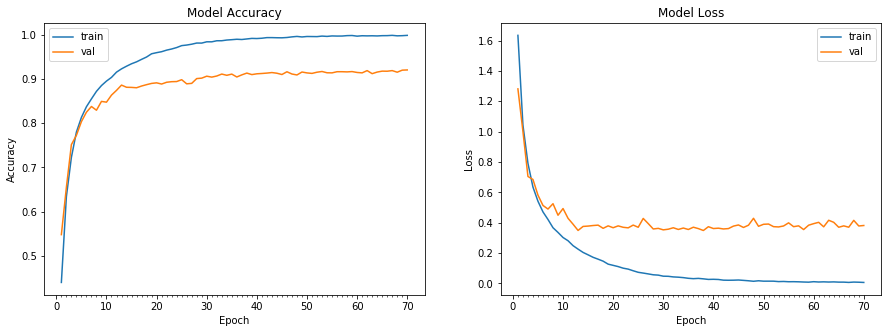

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))   # define a plot with 1 row and 2 columns of subplots
    
# summarize history for accuracy
axs[0].plot(range(1,len(trainAccuracy)+1),trainAccuracy)
axs[0].plot(range(1,len(testAccuracy)+1),testAccuracy)
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(trainAccuracy)+1),len(trainAccuracy)/10)
axs[0].legend(['train', 'val'], loc='best')

# summarize history for loss
axs[1].plot(range(1,len(trainLosses)+1),trainLosses)
axs[1].plot(range(1,len(testLosses)+1),testLosses)
axs[1].set_title('Model Loss') 
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(trainLosses)+1),len(trainLosses)/10)
axs[1].legend(['train', 'val'], loc='best')
plt.show()